### Training

In [1]:
import os
from typing import Dict, Optional
from utils import train, test
from metrics import Summary, Metrics
from matplotlib.pyplot import figure, show, savefig
from matplotlib.axes import Axes

def plot(metrics: Dict[str, Metrics], metric: str, ax: Optional[Axes] = None):
    ax_none = False
    if ax is None:
        plot = figure()
        ax = plot.add_subplot()
        ax_none = True

    for key, value in metrics.items():
        ax.plot(value.history[metric], label=key)
    
    ax.legend()
    ax.set_title(metric)
    ax.set_xlabel('epoch')
    ax.set_ylabel(metric)

    if ax_none:
        show()

def run_experiment(model, optimizer, criterion, device: str, data, summary: Summary, epochs: int = 30):
    summary.open()
    summary.add_text('model', str(model))
    summary.add_text('optimizer', str(optimizer))
    summary.add_text('criterion', str(criterion))

    for epoch in range(epochs):
        train(model, criterion, optimizer, data['train'], summary.metrics['train'], device)
        test(model, criterion, data['test'], summary.metrics['test'], device)

    summary.close()

    metrics_plot = figure(figsize=(10, 5))
    metrics_plot.suptitle(f'{summary.name}')
    ax = metrics_plot.add_subplot(1, 2, 1)
    plot(summary.metrics, 'loss', ax)

    ax = metrics_plot.add_subplot(1, 2, 2)
    plot(summary.metrics, 'accuracy', ax)
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    savefig(f'./plots/{summary.name}-{summary.id}.png')
    show()

Running experiment ViT with id 926ff623-5b8e-4d20-aa81-62f2998c9648
Tensorboard logs are saved in logs/ViT-926ff623-5b8e-4d20-aa81-62f2998c9648
Run tensorboard with: tensorboard --logdir=logs/
Open browser and go to: http://localhost:6006/
----------------------------------------------------------------
model: ViT(
  (image_to_embeddings): Sequential(
    (0): ConvolutionalImagePatchEmbedding(
      (projector): Conv2d(1, 128, kernel_size=(4, 4), stride=(4, 4))
    )
    (1): CLSToken()
    (2): LearnablePositionalEncoding()
    (3): Dropout(p=0.4, inplace=False)
  )
  (transformer): Transformer(
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x Encoder(
        (normalization): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (feed_forward): Sequential(
          (0

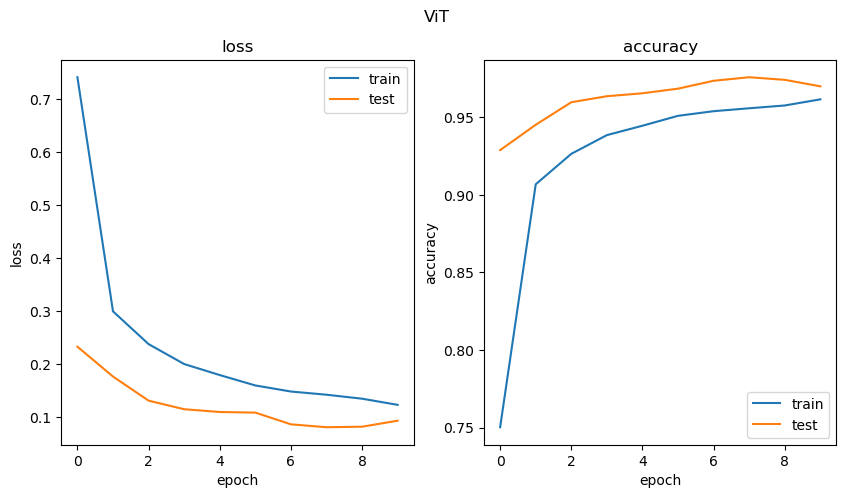

In [2]:
from uuid import uuid4
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Compose
from torch.utils.data import DataLoader
from metrics import Summary
from model.vit import ViT

transforms = Compose([ToTensor()])

device = 'cuda'
loaders = {
    'train': DataLoader(MNIST(root='./data', train=True, download=True, transform=transforms), batch_size=64, shuffle=True, pin_memory=True, pin_memory_device=device, num_workers=4),
    'test': DataLoader(MNIST(root='./data', train=False, download=True, transform=transforms), batch_size=64, shuffle=False, pin_memory=True, pin_memory_device=device)
}

torch.set_float32_matmul_precision('high')
experiment = uuid4()
model = ViT(
    patch_shape=(4, 4),
    model_dimension= 128,
    hidden_dimension=64,
    number_of_layers=4,
    number_of_heads=8,
    number_of_channels=1,
    number_of_classes=10,
    dropout = 0.4,
).to(device)

optimizer = Adam(model.parameters(), lr=0.001)
criterion = CrossEntropyLoss()

summary = Summary(name=model.__class__.__name__, id=experiment)
run_experiment(model, optimizer, criterion, device, loaders, summary, epochs=10)